In [7]:
import os
import math

import cv2
import numpy as np
import os
import gc

import torch

# from detectron2.data.datasets import register_coco_instances
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
# from detectron2.config import get_cfg
# from detectron2.engine import DefaultTrainer
# import detectron2.data.transforms as T
# from detectron2.data import DatasetMapper
# from detectron2 import model_zoo
# from detectron2.config import get_cfg

# import mediapipe as mp


from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.sam2_video_predictor import SAM2VideoPredictor
from sam2.build_sam import build_sam2

import matplotlib.pyplot as plt

from ultralytics import YOLO

from utils.helpers import plot_yolo_keypoints, analyze_yolo_dataset, plot_4x, yolo_to_coco

plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        

using device: cuda


In [3]:
CONFIG = {
    'DATASET_DIR': '/mnt/DL/Projects/pingpong/datasets/table_tennis_table_kpts_dataset',
    'IM_SIZE': 640,
    'NUM_KEYPOINTS': 4,
    'BATCH_SIZE': 8,
    'NUM_EPOCHS': 1000,
    'PATIENCE': 20,
    'NUM_WORKERS': os.cpu_count(),
    'PIN_MEMORY': True,
    'TABLE_WIDTH_CM': 152.5,
    'TABLE_LENGTH_CM': 274,
}

## Data visualization

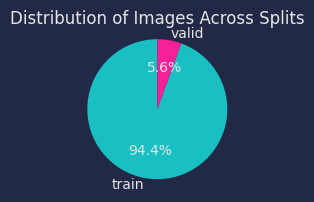

Split  Image Count Percentage
0  train          644     94.43%
1  valid           38      5.57%

In [60]:
analyze_yolo_dataset(CONFIG['DATASET_DIR'])

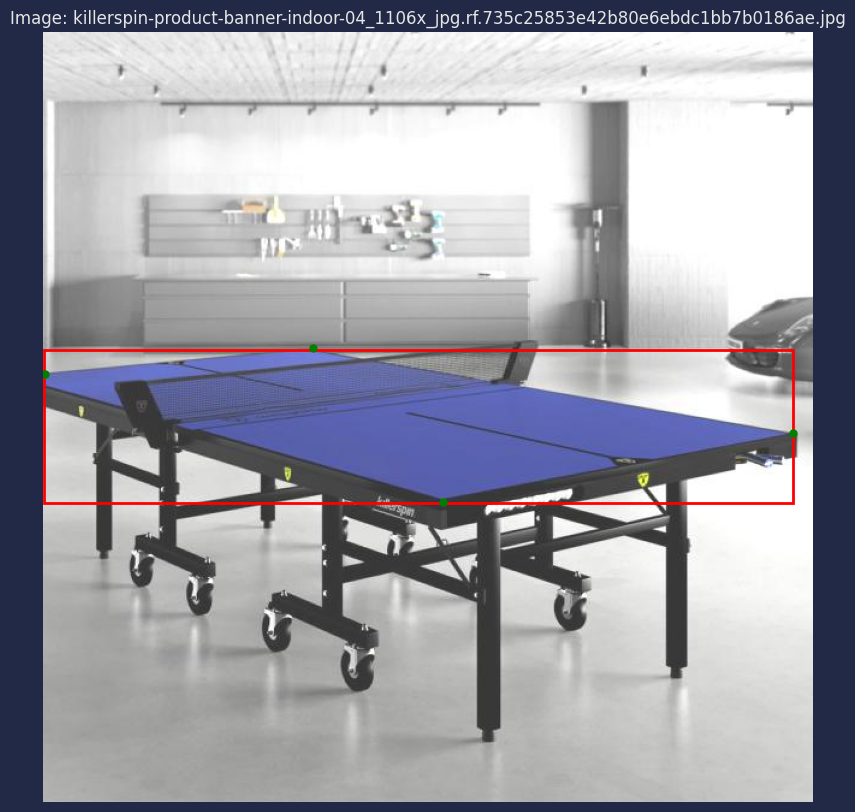

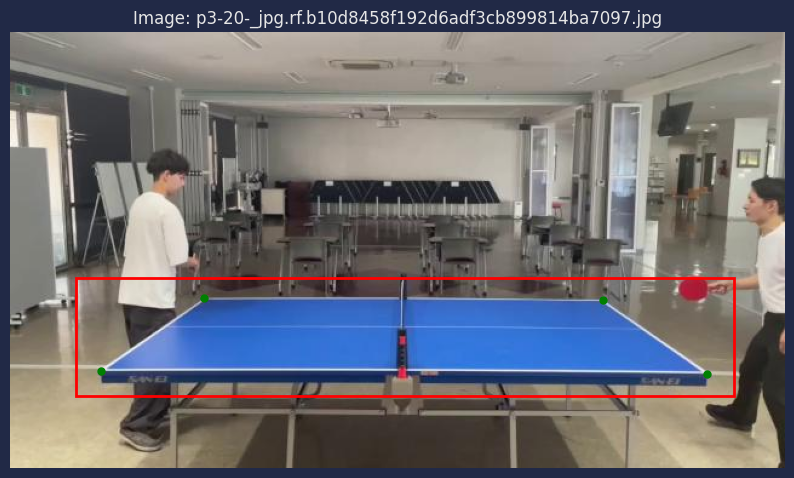

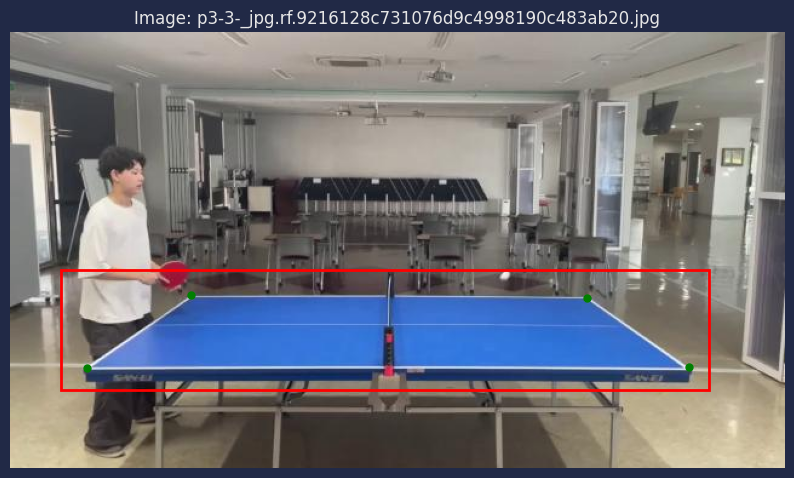

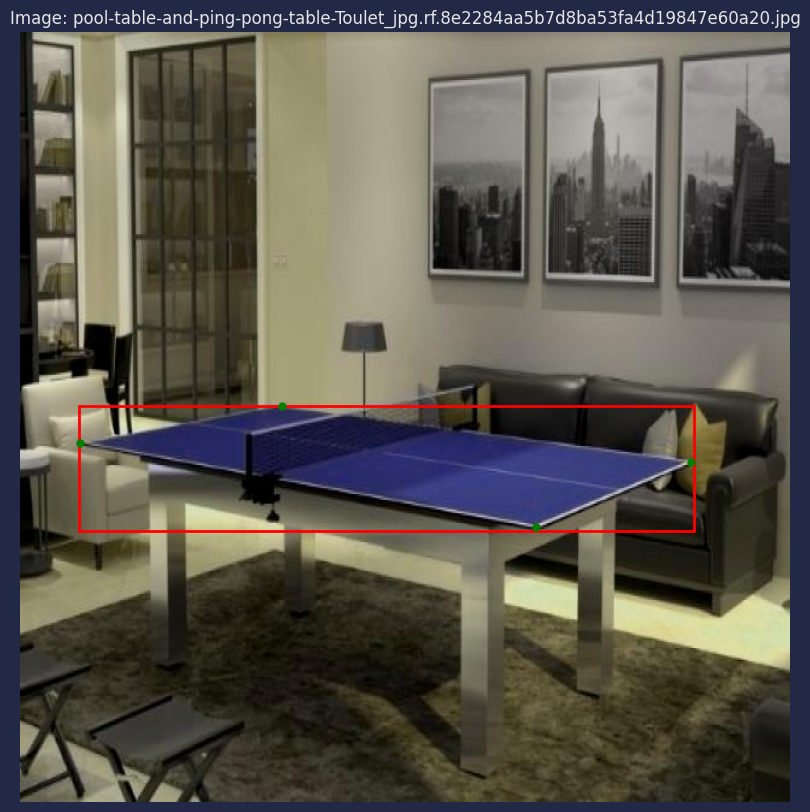

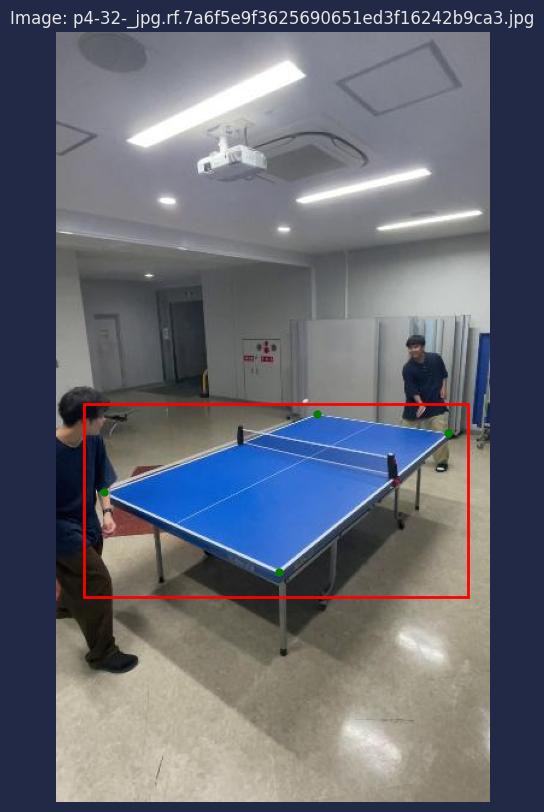

In [61]:
plot_yolo_keypoints(CONFIG['DATASET_DIR'])

# Modeling

In [62]:
yolo_to_coco(CONFIG['DATASET_DIR'])

## YOLOv11 medium Pose

In [63]:
yolov11_model = YOLO("yolo11m-pose.pt")


In [64]:
yolov11_model.info()

YOLO11m-pose summary: 434 layers, 20,912,364 parameters, 0 gradients, 71.9 GFLOPs


(434, 20912364, 0, 71.9384576)

## Detectron

In [65]:
register_coco_instances(
    "my_dataset_train", 
    {}, 
    os.path.join(CONFIG['DATASET_DIR'], "labels", "train", "annotations.json"), 
    os.path.join(CONFIG['DATASET_DIR'])
)


# TRAIN
MetadataCatalog.get("my_dataset_train").keypoint_names = ["kp_1", "kp_2", "kp_3", "kp_4"]
# If kp_1 flips to kp_2 and kp_3 flips to kp_4:
MetadataCatalog.get("my_dataset_train").keypoint_flip_map = [
    ("kp_1", "kp_2"),
    ("kp_3", "kp_4")
]
MetadataCatalog.get("my_dataset_train").evaluator_type = 'coco'
MetadataCatalog.get("my_dataset_train").thing_classes = ["table"]
MetadataCatalog.get("my_dataset_train").thing_dataset_id_to_contiguous_id = {0: 0}
# Example connection rules (you can customize these):
# Each entry is (kpt1, kpt2, color). Color is an (R, G, B) tuple.
MetadataCatalog.get("my_dataset_train").keypoint_connection_rules = [
    ("kp_1", "kp_2", (255, 0, 0)),
    ("kp_2", "kp_3", (0, 255, 0)),
    ("kp_3", "kp_4", (0, 0, 255))
]

# VAL
register_coco_instances(
    "my_dataset_val",
    {},
    os.path.join(CONFIG['DATASET_DIR'], "labels", "valid", "annotations.json"),
    os.path.join(CONFIG['DATASET_DIR'])
)

MetadataCatalog.get("my_dataset_val").keypoint_names = ["kp_1", "kp_2", "kp_3", "kp_4"]
MetadataCatalog.get("my_dataset_val").keypoint_flip_indices = [1, 0, 3, 2]
MetadataCatalog.get("my_dataset_val").keypoint_flip_map = [
    ("kp_1", "kp_2"),
    ("kp_3", "kp_4")
]
MetadataCatalog.get("my_dataset_val").keypoint_connection_rules = [
    ("kp_1", "kp_2", (255, 0, 0)),
    ("kp_2", "kp_3", (0, 255, 0)),
    ("kp_3", "kp_4", (0, 0, 255))
]

In [66]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations= [
            T.Resize((800, 800)),
            T.RandomBrightness(0.8, 1.2),
            T.RandomContrast(0.8, 1.2),
            T.RandomSaturation(0.8, 1.2),
            T.RandomRotation([-30, 30]),
            T.RandomCrop("relative_range", (0.8, 0.8)),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),  # Random horizontal flip
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),  # Random vertical flip
            T.RandomExtent(scale_range=(0.8, 1.2), shift_range=(0.2, 0.2)),
        ])
        return build_detection_train_loader(cfg, mapper=mapper)

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



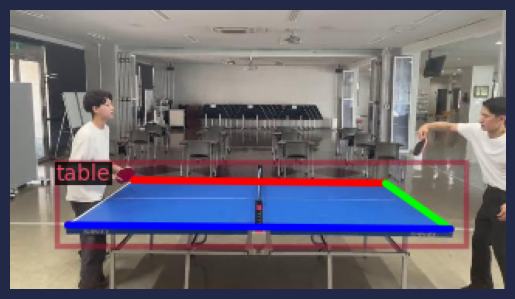

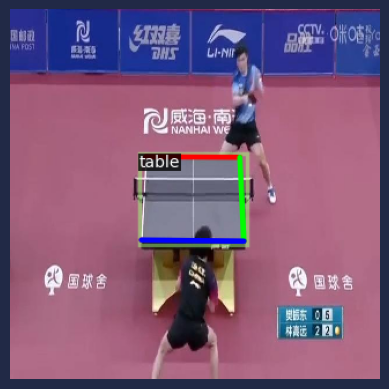

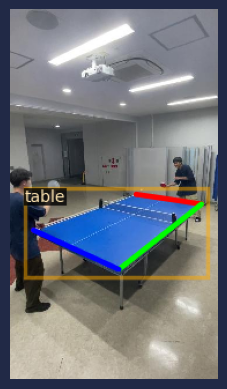

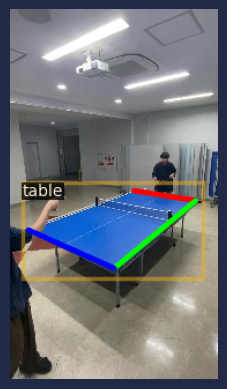

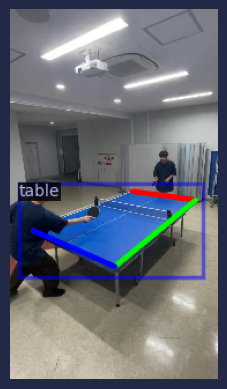

In [67]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

train_metadata = MetadataCatalog.get("my_dataset_val")
dataset_dicts = DatasetCatalog.get("my_dataset_val")
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)   
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## YOLO + SAM + DETR + Homography

In [ ]:
# Utils.py
import sympy
import subprocess
import shutil

def extract_frames(video_path, resize_size=None):
    """
    Extracts frames from a video file and optionally resizes them.
    Parameters:
    video_path (str): Path to the input video file.
    resize_size (int, optional): If provided, resizes the largest dimension of the frames to this size while maintaining aspect ratio.
    Returns:
    tuple: A tuple containing:
        - save_dir (str): Directory where the extracted frames are saved.
        - fps (float): Frames per second of the input video.
    Raises:
    FileNotFoundError: If the video file does not exist.
    Notes:
    - The function uses `ffprobe` to retrieve the frame rate of the video.
    - Frames are extracted using `ffmpeg` and saved as JPEG images in a directory named "extracted" located in the same directory as the input video.
    - If `resize_size` is provided, the frames are resized such that the largest dimension is equal to `resize_size` while maintaining the aspect ratio.
    """

    if not os.path.exists(video_path):
        print("Video Not Found")
        return None, None
    # 1) Retrieve FPS using ffprobe
    probe_cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=r_frame_rate",
        "-of", "csv=p=0",
        video_path
    ]
    result = subprocess.run(probe_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    r_frame_rate = result.stdout.strip()  # e.g. "30/1"
    
    if "/" in r_frame_rate:
        num, den = r_frame_rate.split("/")
        fps = float(num) / float(den) if float(den) != 0 else float(num)
    else:
        fps = float(r_frame_rate)

    # 2) Build ffmpeg command for frame extraction
    save_dir = os.path.join(os.path.dirname(video_path), "extracted")
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok=True)
    output_pattern = os.path.join(save_dir, "%d.jpg")

    ffmpeg_cmd = [
        "ffmpeg", "-i", video_path,
        "-vsync", "0",    # Extract every frame without duplication/dropping
    ]

    # 3) Apply scale if resize_size is provided
    if resize_size:
        # This expression scales the largest dimension to `resize_size` while keeping aspect ratio.
        # If width > height, width becomes `resize_size` and height is set to -1.
        # Otherwise, height is `resize_size` and width is -1.
        scale_filter = (
            f"scale='if(gt(iw,ih),{resize_size},-1)':"
            f"'if(gt(iw,ih),-1,{resize_size})'"
        )
        ffmpeg_cmd += ["-vf", scale_filter]

    ffmpeg_cmd += [output_pattern]

    # 4) Run ffmpeg to perform the extraction
    subprocess.run(ffmpeg_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return save_dir, fps

def line_angle(line):
    x1, y1, x2, y2 = line
    return np.arctan2(y2 - y1, x2 - x1)

def appx_best_fit_ngon(mask_cv2, n: int = 4) -> list[(int, int)]:
    # convex hull of the input mask
    # mask_cv2_gray = cv2.cvtColor(mask_cv2, cv2.COLOR_RGB2GRAY)
    contours, _ = cv2.findContours(
        mask_cv2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    hull = cv2.convexHull(contours[0])
    hull = np.array(hull).reshape((len(hull), 2))

    # to sympy land
    hull = [sympy.Point(*pt) for pt in hull]

    # run until we cut down to n vertices
    while len(hull) > n:
        best_candidate = None

        # for all edges in hull ( <edge_idx_1>, <edge_idx_2> ) ->
        for edge_idx_1 in range(len(hull)):
            edge_idx_2 = (edge_idx_1 + 1) % len(hull)

            adj_idx_1 = (edge_idx_1 - 1) % len(hull)
            adj_idx_2 = (edge_idx_1 + 2) % len(hull)

            edge_pt_1 = sympy.Point(*hull[edge_idx_1])
            edge_pt_2 = sympy.Point(*hull[edge_idx_2])
            adj_pt_1 = sympy.Point(*hull[adj_idx_1])
            adj_pt_2 = sympy.Point(*hull[adj_idx_2])

            subpoly = sympy.Polygon(adj_pt_1, edge_pt_1, edge_pt_2, adj_pt_2)
            angle1 = subpoly.angles[edge_pt_1]
            angle2 = subpoly.angles[edge_pt_2]

            # we need to first make sure that the sum of the interior angles the edge
            # makes with the two adjacent edges is more than 180°
            if sympy.N(angle1 + angle2) <= sympy.pi:
                continue

            # find the new vertex if we delete this edge
            adj_edge_1 = sympy.Line(adj_pt_1, edge_pt_1)
            adj_edge_2 = sympy.Line(edge_pt_2, adj_pt_2)
            intersect = adj_edge_1.intersection(adj_edge_2)[0]

            # the area of the triangle we'll be adding
            area = sympy.N(sympy.Triangle(edge_pt_1, intersect, edge_pt_2).area)
            # should be the lowest
            if best_candidate and best_candidate[1] < area:
                continue

            # delete the edge and add the intersection of adjacent edges to the hull
            better_hull = list(hull)
            better_hull[edge_idx_1] = intersect
            del better_hull[edge_idx_2]
            best_candidate = (better_hull, area)

        if not best_candidate:
            raise ValueError("Could not find the best fit n-gon!")

        hull = best_candidate[0]

    # back to python land
    hull = [(int(x), int(y)) for x, y in hull]

    return hull

def is_dominant_white(image, bbox):
    """
    Determines if the dominant color within the given bounding box is white.
    
    Parameters:
    - image: numpy.ndarray, input image in BGR format.
    - bbox: tuple, bounding box coordinates as (x_min, y_min, x_max, y_max).
    
    Returns:
    - bool: True if white is the dominant color, False otherwise.
    """
    # Convert PIL image to cv2 image
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    x_min, y_min, x_max, y_max = bbox
    # Extract the region of interest from the image
    roi = image[y_min:y_max, x_min:x_max]
    
    # Check if the ROI is empty (invalid bounding box)
    if roi.size == 0:
        return False
    
    # Convert the ROI to HSV color space
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    
    # Split into individual channels
    h, s, v = cv2.split(hsv_roi)
    
    # Define thresholds for saturation and value to identify white pixels
    saturation_threshold = 80
    value_threshold = 100
    dominance_threshold = 0.5  # 70% of the ROI must be white-like
    
    # Create masks for low saturation and high value
    low_saturation = s < saturation_threshold
    high_value = v > value_threshold
    white_pixels = low_saturation & high_value
    
    # Calculate the proportion of white pixels
    white_ratio = np.sum(white_pixels) / white_pixels.size
    
    is_ball = white_ratio >= dominance_threshold
    
    return is_ball

def segment_dominant_color(
    image,
    hue_padding=10,
    sat_padding=80, 
    val_padding=40,
    ignore_low_sat=25,
    ignore_low_val=25
):
    """
    Segments the table in 'image_path' by:
      1. Building a histogram of HSV pixels.
      2. Finding the histogram peak as the 'dominant' color.
      3. Creating a tolerance range around that color to mask the table.
    
    Parameters
    ----------
    image_path: str
        Path to the input image.
    hue_padding: int
        Range around the dominant hue (in [0..179]) to include in the mask.
    sat_padding: int
        Range around the dominant saturation (in [0..255]) to include in the mask.
    val_padding: int
        Range around the dominant value (in [0..255]) to include in the mask.
    ignore_low_sat: int
        Ignore pixels with saturation below this threshold (to skip near-gray).
    ignore_low_val: int
        Ignore pixels with value below this threshold (to skip near-black).
    
    Returns
    -------
    segmented_image: np.ndarray
        BGR image with only the dominant table color region visible.
    mask: np.ndarray
        Binary mask identifying the table region.
    """
    
    # Read image and convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Flatten the HSV image into a list of pixels:
    # shape is (height*width, 3)
    hsv_flat = hsv.reshape(-1, 3)

    # Optionally filter out near-gray or near-black pixels to avoid muddying the histogram
    # for example, ignoring background or shadows.
    mask_filter = (hsv_flat[:, 1] >= ignore_low_sat) & (hsv_flat[:, 2] >= ignore_low_val)
    hsv_filtered = hsv_flat[mask_filter]

    # If everything got filtered out, fallback to a raw histogram
    if len(hsv_filtered) == 0:
        hsv_filtered = hsv_flat

    # Build a 3D histogram in H, S, V
    # Ranges:
    #   Hue: [0..180)
    #   Sat: [0..256)
    #   Val: [0..256)
    # We can keep a coarser bin size to reduce noise, e.g. 180 for hue, 256 for sat/val
    hist_3d, edges = np.histogramdd(
        hsv_filtered.astype(np.float32), 
        bins=(180, 256, 256), 
        range=((0, 180), (0, 256), (0, 256))
    )

    # Find the bin with the largest count. This is the 'mode' (peak) of the color distribution.
    # The index returned will be (h_idx, s_idx, v_idx).
    peak_idx = np.unravel_index(np.argmax(hist_3d), hist_3d.shape)

    # Convert bin index to approximate color value
    #   each bin has a certain width in each dimension:
    #   - hue_width ~ 1.0
    #   - sat_width ~ 1.0
    #   - val_width ~ 1.0
    # For integer bins, the center of bin i is roughly i.
    # Adjust as you see fit; here we treat the bin index as the actual HSV.
    dominant_h = peak_idx[0]
    dominant_s = peak_idx[1]
    dominant_v = peak_idx[2]

    # Build a tolerance range around the dominant color
    lower_h = max(dominant_h - hue_padding, 0)
    upper_h = min(dominant_h + hue_padding, 179)
    lower_s = max(dominant_s - sat_padding, 0)
    upper_s = min(dominant_s + sat_padding, 255)
    lower_v = max(dominant_v - val_padding, 0)
    upper_v = min(dominant_v + val_padding, 255)

    lower_bound = np.array([lower_h, lower_s, lower_v], dtype=np.uint8)
    upper_bound = np.array([upper_h, upper_s, upper_v], dtype=np.uint8)

    # Create mask using the dynamic range
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # (Optional) Refine with morphological operations to clean up noise
    # kernel = np.ones((5, 5), np.uint8)
    # mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Apply mask
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    return segmented_image

def corner_distances(corners):
    """
    corners: ndarray (4, 2) => [[x0, y0],
                               [x1, y1],
                               [x2, y2],
                               [x3, y3]]
    returns: list of 6 floats (all unique distances between the 4 points)
    """
    pairs = [(0,1), (1,2), (2,3), (3,0), (0,2), (1,3)]
    dists = []
    for (i, j) in pairs:
        d = np.linalg.norm(corners[i] - corners[j])
        dists.append(d)
    return dists

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

### Table Tracking


0: 640x384 1 table, 11.3ms
Speed: 0.9ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 table, 12.1ms
Speed: 0.9ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 tables, 11.2ms
Speed: 0.9ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 tables, 21.9ms
Speed: 0.8ms preprocess, 21.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 table, 9.3ms
Speed: 0.8ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 tables, 8.7ms
Speed: 0.9ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 tables, 12.0ms
Speed: 0.8ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 table, 12.6ms
Speed: 0.8ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


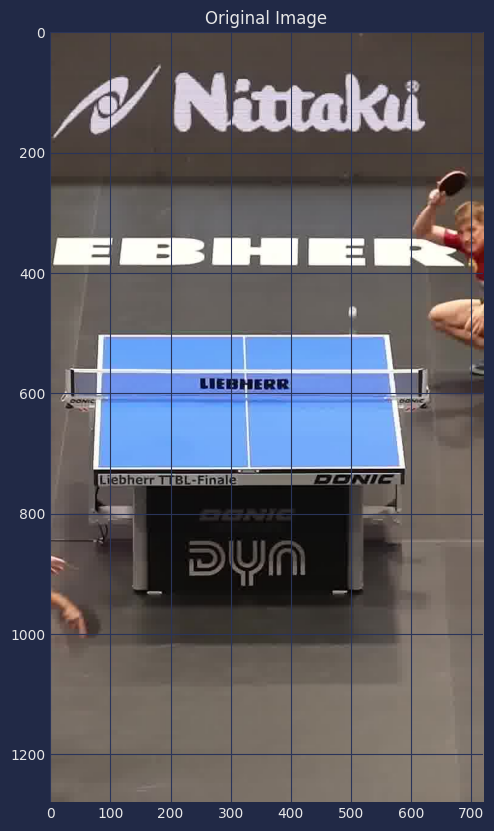

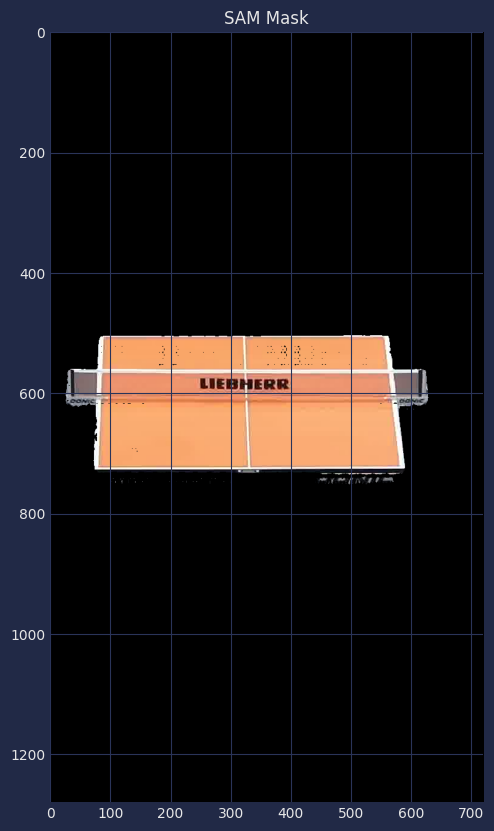

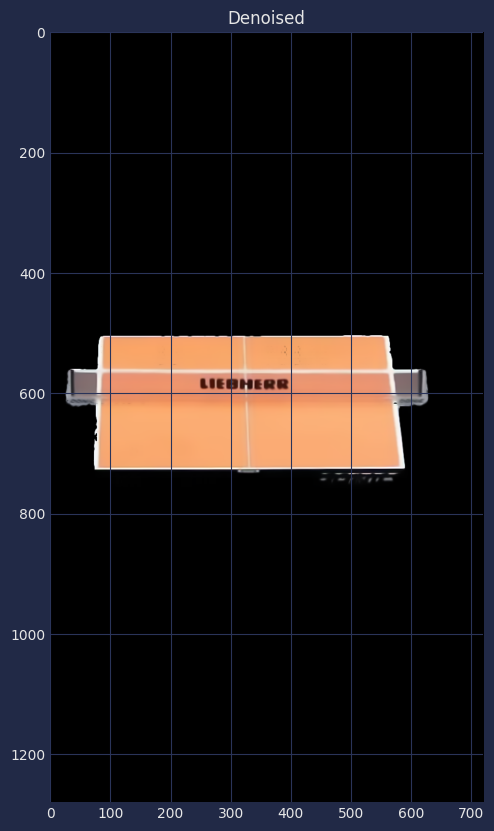

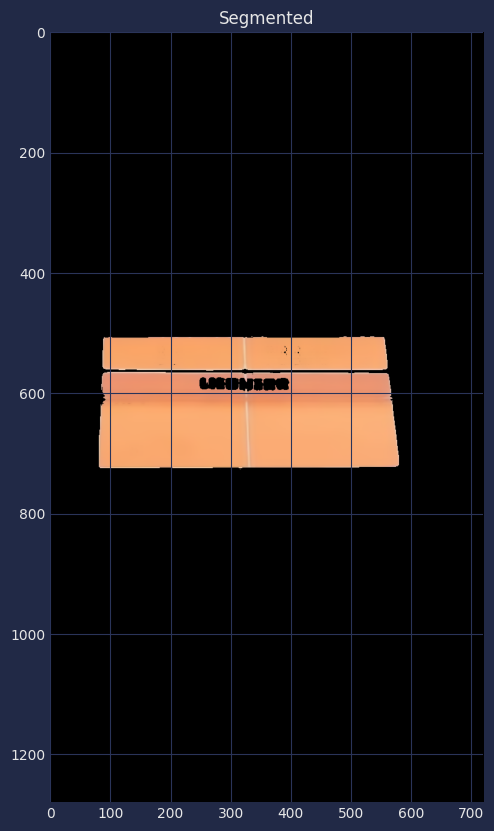

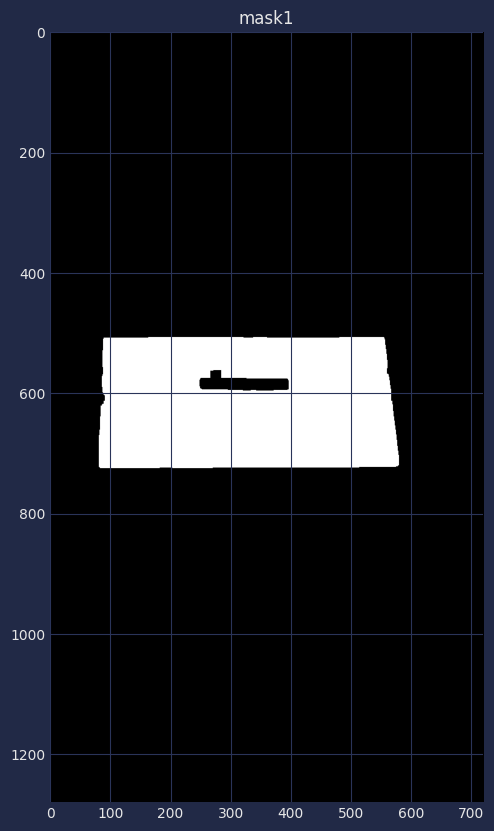

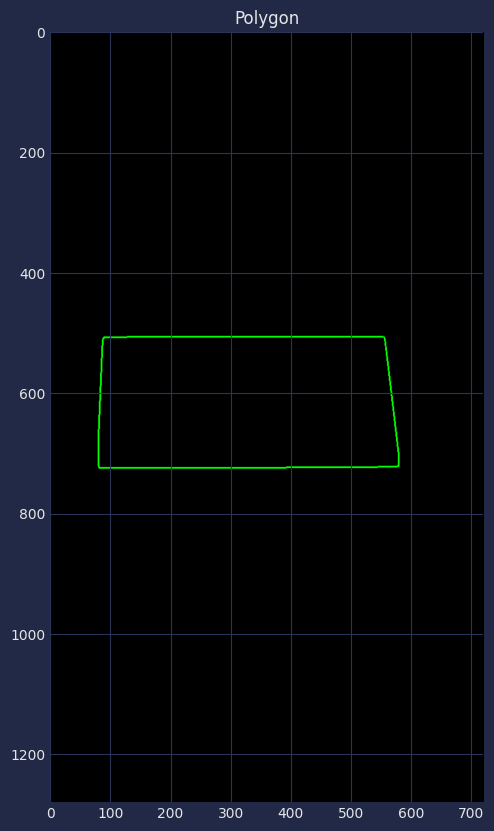

Found table corners at frame 150


In [ ]:
class TableDetector:
    def __init__(self, video_path, yolo_model_path="../runs/pose/train5/weights/best.pt",
                 sam_model_path="../sam2/checkpoints/sam2.1_hiera_large.pt",
                 sam_config_path="configs/sam2.1/sam2.1_hiera_l.yaml",
                 visualize=False):
        self.video_path = video_path
        self.yolo_model_path = yolo_model_path
        self.sam_model_predictor = SAM2ImagePredictor(build_sam2(sam_config_path, sam_model_path))
        self.visualize= visualize
        save_dir, self.fps = extract_frames(self.video_path, resize_size=None)
        self.frames = [cv2.imread(os.path.join(save_dir, f)) for f in sorted(os.listdir(save_dir))]

    def detect_table_bbox(self, image):
        table_yolo_model = YOLO(self.yolo_model_path)
        results = table_yolo_model.predict(source=image)
        bbox_table = None
        for result in results:
            for box in result.boxes:
                # Just take the first bounding box found
                bbox_table = box.xyxy[0].tolist()  # [x1, y1, x2, y2]
                break
        return bbox_table

    def segment_table(self, image, input_point=None, input_label=None, input_box=None):
        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            self.sam_model_predictor.set_image(image)
            masks, scores, logits = self.sam_model_predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                box=input_box,
                multimask_output=True,
            )
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            scores = scores[sorted_ind]
            logits = logits[sorted_ind]
        return masks, scores, logits

    def detect_table_edges(self, idx, num_secs=7):
        """
        1. Search a span of frames around 'idx' to find the best table mask (largest area).
        2. Return the corner points for the best mask, sorted such that:
        - The points on the left (relative to a normalized direction_line) come first,
        - Ordered as: top-left, bottom-left, bottom-right, top-right.
        
        (If a direction_line is available, it is rotated so that it points between 0 and 90° 
        relative to the positive x-axis.)
        """
        biggest_mask_area = 0
        best_mask = None
        best_image = None
        best_idx = -1

        # ------------------------------------------------------------------
        # 1. Find "best" frame for table detection in next num_secs of video
        # ------------------------------------------------------------------
        for local_i, frame in enumerate(
            self.frames[idx: int(idx + self.fps * num_secs)
                        if idx + self.fps * num_secs < len(self.frames)
                        else len(self.frames)]
        ):
            # Skip some frames to speed up searching
            if local_i % 10 != 0:
                continue

            table_bbox = self.detect_table_bbox(frame)
            if not table_bbox:
                continue

            table_masks, table_scores, table_logits = self.segment_table(
                image=frame,
                input_label=np.array([1]),
                input_box=table_bbox
            )
            highest_score_mask_index = np.argmax(table_scores)
            highest_socre_mask = table_masks[highest_score_mask_index]
            mask_area = np.sum(highest_socre_mask)
            if mask_area > biggest_mask_area:
                biggest_mask_area = mask_area
                best_mask = highest_socre_mask
                best_image = frame
                best_idx = idx + local_i

        if best_idx == -1 or best_mask is None:
            print("No suitable table mask found.")
            return None

        # -------------------------------
        # 2. Post-process to get corners
        # -------------------------------
        # Apply the mask to get the cropped image
        mask_crop_image = cv2.bitwise_and(best_image, best_image, mask=best_mask.astype(np.uint8))

        # Denoise and segment
        denoised_image = cv2.fastNlMeansDenoising(mask_crop_image, h=40)
        segmented = segment_dominant_color(denoised_image)
        segmented_bw = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)

        # Thresholding and morphological operations
        thresholded = cv2.threshold(segmented_bw, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        struc1 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
        mask_crop_gray = cv2.cvtColor(mask_crop_image, cv2.COLOR_BGR2GRAY)
        opened = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, struc1)
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, struc1, iterations=1)
        edges = cv2.Canny(closed, 50, 100)
        # edges_2 = cv2.Canny(mask_crop_gray, 50, 100)

        contours, _ = cv2.findContours(edges.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not contours:
            print("No contours found.")
            return None

        all_points = np.vstack(contours)
        hull = cv2.convexHull(all_points)
        hull_image = np.zeros_like(mask_crop_image)
        cv2.drawContours(hull_image, [hull], -1, (0, 255, 0), 2)
        poly = appx_best_fit_ngon(cv2.cvtColor(hull_image, cv2.COLOR_BGR2GRAY), 4)
        
        # We'll store corners in a dict: {best_idx: [(x0, y0), (x1, y1), (x2, y2), (x3, y3)]}
        table_pts = {
            best_idx: [(int(pt[0]), int(pt[1])) for pt in poly]
        }
        

        # Optional visualization
        if self.visualize:
            self.visualize_results(
                image=self.frames[best_idx],
                mask_crop_image=mask_crop_image,
                denoised_image=denoised_image,
                segmented=segmented,
                closed=closed,
                hull_image=hull_image,
            )
        return table_pts

    def track_table_points(self, table_pts, distance_threshold=100):
        """
        table_pts: dict with a single key = reference frame index, 
                   value = list of 4 corners (x, y).
                   
        We'll do a feature-based approach using ORB + RANSAC homography:
          1. Extract features in the reference frame.
          2. For each other frame, detect features, match them, compute homography H with RANSAC.
          3. Warp the reference corners by H.
          4. Save the resulting corners in a dict { frame_idx: corners }.
        """
        # --------------------------------
        # 1. Prepare reference data
        # --------------------------------

        # ORB initialization
        orb = cv2.ORB_create(nfeatures=2000)

        # We'll store corners for each frame
        tracked_table_points = table_pts.copy()

        # --------------------------------
        # 2. Function to compute corners via RANSAC for each new frame
        # --------------------------------
        def compute_homography_and_transform_corners(ref_frame_idx, curr_frame_idx):
            """
            Return the new corners for the corners in ref_corners by applying 
            the RANSAC homography from reference_frame -> current_frame.
            """
            
            ref_frame = self.frames[ref_frame_idx]
            curr_frame = self.frames[curr_frame_idx]
            
            curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
            ref_gray = cv2.cvtColor(ref_frame, cv2.COLOR_BGR2GRAY)
            ref_corners = np.array(tracked_table_points[ref_frame_idx], dtype=np.float32).reshape(-1, 1, 2)
            
            # Detect and compute with ORB
            keypoints_ref, descriptors_ref = orb.detectAndCompute(ref_gray, None)
            keypoints_curr, descriptors_curr = orb.detectAndCompute(curr_gray, None)
            if descriptors_curr is None or len(keypoints_curr) < 4:
                return None  # not enough features

            # BFMatcher to match features
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(descriptors_ref, descriptors_curr)
            # knn_matches = bf.knnMatch(descriptors_ref, descriptors_curr, k=2)
            # ratio = 0.7  # typical ratio test value
            if not matches:
                return None

            # Sort matches by distance
            matches = sorted(matches, key=lambda x: x.distance)[:100]
            # You might want to filter top-k, e.g., top 200, or use ratio test etc.

            # Coordinates in reference frame
            ref_pts = np.float32([keypoints_ref[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            # Coordinates in current frame
            curr_pts = np.float32([keypoints_curr[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            # Find homography with RANSAC
            H, mask = cv2.findHomography(ref_pts, curr_pts, cv2.RANSAC, 1)
            if H is None:
                return None

            # Warp the reference corners
            new_corners = cv2.perspectiveTransform(ref_corners, H)
            # Convert corners to a Python list of (x,y)
            new_corners_array = np.array([
                [int(pt[0][0]), int(pt[0][1])] for pt in new_corners
            ])
            return new_corners_array

        # --------------------------------
        # 3. Track for all frames
        # --------------------------------
        # A. Backward propagation (ref_idx -> 0)
        init_ref_idx = next(iter(tracked_table_points.keys()))
        ref_corners = np.array(tracked_table_points[init_ref_idx], dtype=np.float32).reshape(-1, 1, 2)
        ref_index = init_ref_idx
        for i in range(init_ref_idx - 1, -1, -1):
            new_corners = compute_homography_and_transform_corners(ref_index, i)
            if new_corners is None:
                print("Falling back to previous frame.")
                # fallback: re-use corners from previous known frame
                tracked_table_points[i] = tracked_table_points[i + 1]
                continue
            new_corners_2d = np.array(new_corners, dtype=np.float32).reshape(-1, 2)
            tracked_table_points[i] = new_corners
            moved_corners = any(np.linalg.norm(pp - cp) > distance_threshold for pp, cp in zip(ref_corners, new_corners_2d))
            if moved_corners:
                ref_corners = tracked_table_points[i + 1]
                ref_index = i + 1
            
        # B. Forward propagation (ref_idx -> end)
        ref_corners = np.array(tracked_table_points[init_ref_idx], dtype=np.float32).reshape(-1, 1, 2)
        for i in range(init_ref_idx + 1, len(self.frames)):
            new_corners = compute_homography_and_transform_corners(ref_index, i)
            if new_corners is None:
                print("Falling back to previous frame.")
                # fallback: re-use corners from previous known frame
                tracked_table_points[i] = tracked_table_points[i - 1]
                continue
            new_corners_2d = np.array(new_corners, dtype=np.float32).reshape(-1, 2)
            tracked_table_points[i] = new_corners
            moved_corners = any(np.linalg.norm(pp - cp) > distance_threshold for pp, cp in zip(ref_corners, new_corners_2d))
            if moved_corners:
                ref_corners = tracked_table_points[i - 1]
                ref_index = i - 1
        return tracked_table_points

    def process_video(self, output_video=False):
        """
        Main pipeline:
          1. Loop frames to find the table bounding box & corners in one “best” frame.
          2. Use that frame’s corners + feature-based RANSAC homography to track corners through entire video.
          3. Write an output video with the tracked corners drawn on each frame.
        """
        # 1. Detect table corners in some frame
        table_pts = None
        for idx, frame in enumerate(self.frames):
            bbox = self.detect_table_bbox(frame)
            if bbox:
                table_pts = self.detect_table_edges(idx)
                if table_pts:
                    print(f"Found table corners at frame {next(iter(table_pts.keys()))}")
                    tracked_points = self.track_table_points(table_pts)
                    if not output_video:
                        return tracked_points
                    else:
                        break
                else:
                    print("Table not found.")
                    return None
                        
        if output_video and tracked_points:
            output_path = os.path.join(os.path.dirname(self.video_path), "output.avi")
            output_dir = os.path.dirname(output_path)
            if not os.path.exists(output_dir):
                print(f"Creating output directory: {output_dir}")
                os.makedirs(output_dir, exist_ok=True)

            if not os.access(output_dir, os.W_OK):
                print(f"NO WRITE PERMISSIONS for: {output_dir}")
                return
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            out = cv2.VideoWriter(
                output_path,
                fourcc,
                self.fps,
                (int(self.frames[0].shape[1]), int(self.frames[0].shape[0]))
            )
            # Check if VideoWriter is opened successfully
            if not out.isOpened():
                print("Error: Failed to open VideoWriter. Check codec support or output path.")
                return

            # 3. Write output video frames, drawing the tracked corners
            for i, frame in enumerate(self.frames):
                corners_i = tracked_points.get(i, None)
                if corners_i is not None:
                    for pt in corners_i:
                        x, y = int(pt[0]), int(pt[1])
                        if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
                            cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)
                out.write(frame)

            out.release()
            print(f"Done. Output saved to: {output_path}")
        return tracked_points
            
    def visualize_results(self, image, mask_crop_image, denoised_image, segmented, closed, hull_image):
        # Display the results
        plt.figure(figsize=(10, 10))
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        plt.figure(figsize=(10, 10))
        plt.title("SAM Mask")
        plt.imshow(mask_crop_image)
        
        plt.figure(figsize=(10, 10))
        plt.title("Denoised")
        plt.imshow(denoised_image)
        
        plt.figure(figsize=(10, 10))
        plt.title("Segmented")
        plt.imshow(segmented)
        
        plt.figure(figsize=(10, 10))
        plt.title("mask1")
        plt.imshow((cv2.cvtColor(closed, cv2.COLOR_GRAY2RGB)))

        plt.figure(figsize=(10, 10))
        plt.title("Polygon")
        plt.imshow(hull_image)
        
        plt.show()
detector = TableDetector(video_path="../media/clip2.mp4", visualize=True)
table_track = detector.process_video(output_video=False)

### Ball Tracking

/opt/conda/envs/ping/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Could not load the custom kernel for multi-scale deformable attention: Error building extension 'MultiScaleDeformableAttention': [1/2] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output ms_deform_attn_cuda.cuda.o.d -DTORCH_EXTENSION_NAME=MultiScaleDeformableAttention -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/opt/conda/envs/ping/lib/python3.10/site-packages/transformers/kernels/deformable_detr -isystem /opt/conda/envs/ping/lib/python3.10/site-packages/torch/include -isystem /opt/conda/envs/ping/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/envs/ping

Found the ball at frame 34 with box: [411, 270, 426, 290]


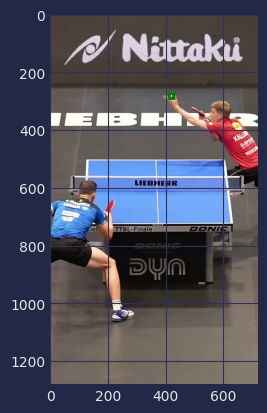

Final box: [        154         101         159         108]


frame loading (JPEG): 100%|██████████| 687/687 [00:11<00:00, 61.46it/s]


added box


propagate in video: 100%|██████████| 653/653 [00:22<00:00, 28.81it/s]


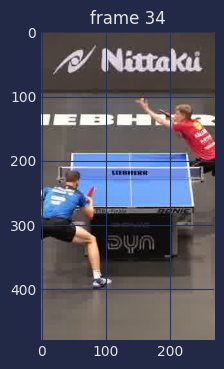

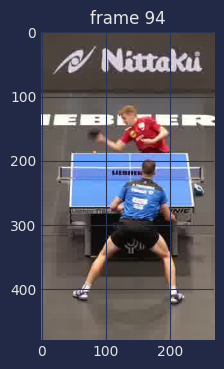

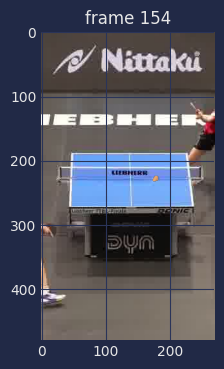

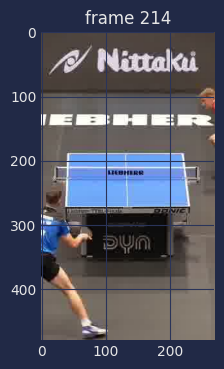

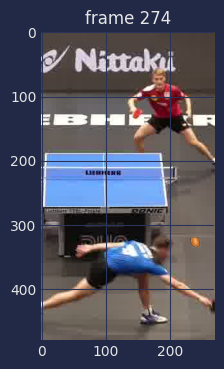

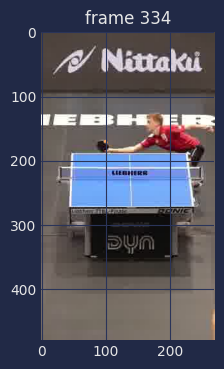

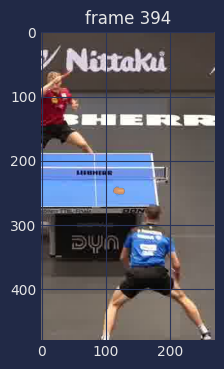

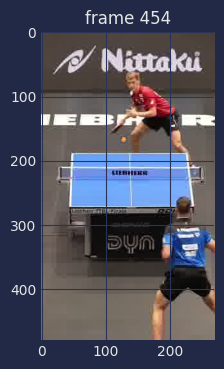

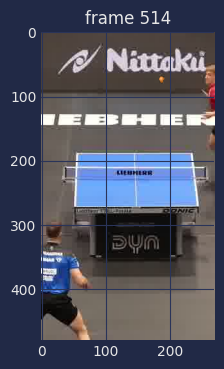

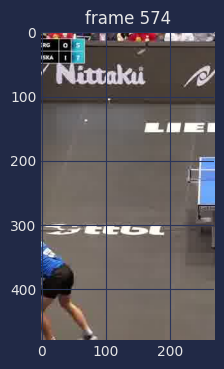

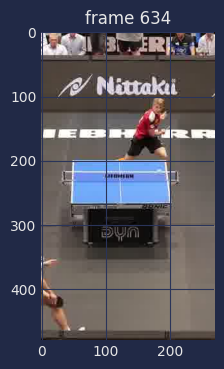

In [ ]:
# BallTracker.py
import numpy as np
import cv2
import torch
from PIL import Image
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
import pandas as pd
from sam2.build_sam import build_sam2_video_predictor

sam_model_path="../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

class BallTracker:
    def __init__(self, video_path, save_dir, visualize=False):
        self.save_dir = save_dir
        self.video_path = video_path
        self.frame_paths = sorted([os.path.join(self.save_dir, p) for p in os.listdir(save_dir) if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]], key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # scan all the JPEG frame names in this directory
        self.sam_predictor = build_sam2_video_predictor(model_cfg, sam_model_path, device=device, offload_video_to_cpu=True, async_loading_frames=True)
        self.visualize = visualize
            
    def find_ball_frame(self):
        try:
            image_processor = RTDetrImageProcessor.from_pretrained("jadechoghari/RT-DETRv2", cache_dir="../chkpts")
            model = RTDetrForObjectDetection.from_pretrained("jadechoghari/RT-DETRv2", cache_dir="../chkpts")
            cap = cv2.VideoCapture(self.video_path)
            frame_idx = 0
            if self.frame_paths:
                sample_image = cv2.imread(self.frame_paths[0])
                scaled_height, scaled_width = sample_image.shape[:2]
            else:
                raise ValueError("No frames found in save_dir")
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                inputs = image_processor(images=image, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(**inputs)
                results = image_processor.post_process_object_detection(outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=0.5)

                for result in results:
                    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
                        if label_id.item() == 32:
                            box = [int(i) for i in box.tolist()]
                            if is_dominant_white(frame, box):
                                print(f"Found the ball at frame {frame_idx} with box: {box}")
                                if self.visualize:
                                    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                                    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='green', facecolor='none', linewidth=2))
                                    plt.show()
                                    
                                # Rescale the box to the resized frame dimensions (floats, not integers)
                                box = [
                                    max(0.0, min(box[0] * scaled_width / image.size[0], scaled_width - 1)),
                                    max(0.0, min(box[1] * scaled_height / image.size[1], scaled_height - 1)),
                                    max(0.0, min(box[2] * scaled_width / image.size[0], scaled_width - 1)),
                                    max(0.0, min(box[3] * scaled_height / image.size[1], scaled_height - 1)),
                                ]
                                final_box = np.array([np.float32(int(p)) for p in box], dtype=np.float32)
                                print(f"Final box: {final_box}")
                                return frame_idx, final_box
                frame_idx += 1
            return None, None
            
        finally:
            cap.release()
            del model
            del image_processor
            torch.clear_autocast_cache()
            torch.cuda.empty_cache()
            gc.collect()
        
    def track_ball(self, frame_idx, bbox):
        # frame_idx, bbox = self.find_ball_frame()
        try:
            if frame_idx is None or bbox is None:
                print("Ball can't be found")
                return
            
            # run propagation throughout the video and collect the results in a dict
            inference_state = self.sam_predictor.init_state(video_path=self.save_dir)
            ann_obj_id = 1
            self.sam_predictor.add_new_points_or_box(
                                inference_state=inference_state,
                                frame_idx=frame_idx,
                                obj_id=ann_obj_id,
                                box=bbox,
                            )
            video_segments = {}  # video_segments contains the per-frame segmentation results
            for out_frame_idx, out_obj_ids, out_mask_logits in self.sam_predictor.propagate_in_video(inference_state):
                video_segments[out_frame_idx] = {
                    out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                    for i, out_obj_id in enumerate(out_obj_ids)
                }
            if self.visualize:
                # render the segmentation results every few frames
                vis_frame_stride = 60
                # plt.close("all")
                for out_frame_idx in range(frame_idx, len(self.frame_paths), vis_frame_stride):
                    frame = cv2.imread(self.frame_paths[out_frame_idx])
                    plt.figure(figsize=(6, 4))
                    plt.title(f"frame {out_frame_idx}")
                    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
                        
            ball_detections = {}
            for seg_frame_idx, seg in video_segments.items():
                # Ensure a list is initialized for this frame
                ball_detections[seg_frame_idx] = []
                for obj_id, mask in seg.items():
                    y, x = np.where(mask[0])
                    if len(x) > 0 and len(y) > 0:
                        center_x = int(np.mean(x))
                        center_y = int(np.mean(y))
                        ball_detections[seg_frame_idx].append((center_x, center_y, 1))
                    else:
                        ball_detections[seg_frame_idx].append((np.nan, np.nan, -1))

            data = []
            for frame, detections in ball_detections.items():
                if detections:  # If there is at least one detection
                    # Here, we select the first detection.
                    x, y, status = detections[0]
                else:
                    x, y, status = np.nan, np.nan, -1
                data.append({'frame': frame, 'x': x, 'y': y, 'status': status})

            # Create the DataFrame and set the frame as index.
            df = pd.DataFrame(data).set_index('frame')

            # Convert x and y to numeric types (this is crucial for interpolation).
            df['x'] = pd.to_numeric(df['x'], errors='coerce')
            df['y'] = pd.to_numeric(df['y'], errors='coerce')

            # Interpolate missing values in x and y.
            df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear', limit_direction='both')

            # Convert back to the original format (tuple for each frame).
            # Here, we reassemble each row into a tuple (x, y, 1) if values exist.
            interpolated_ball_detections = df.apply(
                lambda row: (row['x'], row['y'], 1) if not pd.isna(row['x']) and not pd.isna(row['y'])
                else (np.nan, np.nan, -1),
                axis=1
            ).to_dict()

            return interpolated_ball_detections

        except Exception as e:
            print(f"An error occurred: {e}")
        finally:
            if 'inference_state' in locals():
                self.sam_predictor.reset_state(inference_state)
            del self.sam_predictor
            torch.clear_autocast_cache()
            torch.cuda.empty_cache()
    
save_dir, _ = extract_frames("../media/clip2.mp4", resize_size=480)
bt = BallTracker(video_path="../media/clip2.mp4", save_dir=save_dir, visualize=True)
frame_idx, bbox = bt.find_ball_frame()
ball_track = bt.track_ball(frame_idx, bbox)

### Human Tracking

In [ ]:
# HumanTracker.py
class HumanTracker:
    def __init__(self, model, video_path, table_track, save_video=False):
        self.model = model
        self.video_path = video_path
        self.tracked_ids = []  # Stores the track IDs of the two largest humans
        self.save_video = save_video
        self.table_track = table_track
        self.human_tracks = None
        self.best_edge_idx = None
        self.best_frame = None
    def track_players(self):
        # Process the video with tracking enabled
        results = self.model.track(source=self.video_path, persist=True, save=self.save_video, classes=[0], conf=0.5, tracker="bytetrack.yaml")
        
        # Initialize storage for the two largest humans' tracks
        self.human_tracks = {frame_idx: {0: [], 1: []} for frame_idx in range(len(results))}  # frame_idx: {0: largest, 1: second largest}

        for frame_idx, result in enumerate(results):
            if (
                not result.boxes or 
                result.boxes.xyxy is None or 
                result.boxes.cls is None or 
                result.boxes.id is None
            ):
                if frame_idx == len(results) - 1:
                    return self.human_tracks
                continue  # Skip this frame if any attribute is missing
            # Extract current frame's human detections with track IDs and areas
            humans = []
            for box, cls, track_id in zip(result.boxes.xyxy, result.boxes.cls, result.boxes.id):
                if cls == 0:  # Class 0 for humans
                    x1, y1, x2, y2 = box.tolist()
                    cx = (x1 + x2) / 2
                    cy = (y1 + y2) / 2
                    humans.append((track_id, [x1, y1, x2, y2], (cx, cy)))
            
            # Select the two humans closest to the center of the table in the first qualifying frame
            if not self.tracked_ids:
                if len(humans) >= 2:
                    # Calculate the center of the table
                    table_poly = self.table_track.get(frame_idx)
                    if table_poly is None:
                        continue
                    table_center_x = sum([point[0] for point in table_poly]) / 4
                    table_center_y = sum([point[1] for point in table_poly]) / 4

                    # Calculate distances to the table center and sort by distance
                    sorted_humans = sorted(humans, key=lambda x: ((x[2][0] - table_center_x) ** 2 + (x[2][1] - table_center_y) ** 2) ** 0.5)
                    self.tracked_ids = [sorted_humans[0][0], sorted_humans[1][0]]
                    # Record initial frame's bounding boxes
                    self.human_tracks[frame_idx][0] = (sorted_humans[0][1])
                    self.human_tracks[frame_idx][1] = (sorted_humans[1][1])
                    print(f"Selected humans from frame: {frame_idx}")
                else:
                    continue  # Skip until two humans are found
            else:
                # Collect bounding boxes for the tracked IDs in subsequent frames
                id0_box = None
                id1_box = None
                for human in humans:
                    track_id, bbox, _ = human
                    if track_id == self.tracked_ids[0]:
                        id0_box = bbox
                    elif track_id == self.tracked_ids[1]:
                        id1_box = bbox
                
                # Append boxes if found
                if id0_box:
                    self.human_tracks[frame_idx][0] = id0_box
                if id1_box:
                    self.human_tracks[frame_idx][1] = id1_box
        
        return self.human_tracks
    
    def find_most_parallel_line(self):
        """
        Finds the line between players (from any frame) that is MOST PARALLEL 
        to any table edge across all frames. Returns:
        - best_edge_idx: 0-3 (edge index in polygon)
        - best_frame: frame number where this occurred
        - min_angle_diff: smallest angular difference found
        """
        min_angle_diff = float('inf')
        self.best_edge_idx = -1
        self.best_frame = -1

        # Process all frames with both tracks and table data
        valid_frames = set(self.human_tracks.keys()).intersection(self.table_track.keys())
        for frame_idx in valid_frames:
            # Get player bounding boxes for this frame
            bbox0 = self.human_tracks[frame_idx][0]
            bbox1 = self.human_tracks[frame_idx][1]
            if not bbox0 or not bbox1:
                continue

            # Calculate centers of the two players
            cx0 = (bbox0[0] + bbox0[2]) / 2
            cy0 = (bbox0[1] + bbox0[3]) / 2
            cx1 = (bbox1[0] + bbox1[2]) / 2
            cy1 = (bbox1[1] + bbox1[3]) / 2

            # Calculate angle of the line between players
            dx = cx1 - cx0
            dy = cy1 - cy0
            player_angle = math.degrees(math.atan2(dy, dx))

            # Get table polygon points (handle both list and array formats)
            poly = self.table_track.get(frame_idx)
            if poly is None:
                continue

            # Check all 4 edges of the table polygon
            for edge_idx in range(4):
                pt1 = poly[edge_idx]
                pt2 = poly[(edge_idx + 1) % 4]

                # Calculate edge angle
                dx_edge = pt2[0] - pt1[0]
                dy_edge = pt2[1] - pt1[1]
                edge_angle = math.degrees(math.atan2(dy_edge, dx_edge))

                # Calculate angular difference (0°-90° range)
                diff = abs(player_angle - edge_angle) % 180
                angle_diff = min(diff, 180 - diff)

                # Update best match if this is the most parallel so far
                if angle_diff < min_angle_diff:
                    min_angle_diff = angle_diff
                    self.best_edge_idx = edge_idx
                    self.best_frame = frame_idx
        return {
            "edge_index": self.best_edge_idx,
            "frame": self.best_frame,
            "angle_diff": min_angle_diff,
            "points": (poly[self.best_edge_idx], poly[(self.best_edge_idx + 1) % 4]),
            "indices": (self.best_edge_idx, (self.best_edge_idx + 1) % 4),
            "tracked_ids": self.tracked_ids
        }
        
    def sort_points(self):
        """
        Re-orders the table_track polygons so that every frame's polygon is sorted 
        relative to the orientation defined by the best edge from best_frame.
        The desired order is: [top left, bottom left, top right, bottom right].

        This method rotates the best frame's polygon by the smallest angle that
        makes the best edge vertical (aligned with the y-axis) without flipping 
        the table horizontally. After rotation, the points are split into left and 
        right groups based on their x-values.
        """
        # Ensure find_most_parallel_line has been run.
        if self.best_edge_idx < 0 or self.best_frame < 0:
            print("Please run find_most_parallel_line first.")
            return

        # --- Helper function to rotate a point ---
        def rotate_point(pt, theta, origin=(0, 0)):
            ox, oy = origin
            px, py = pt
            qx = ox + math.cos(theta) * (px - ox) - math.sin(theta) * (py - oy)
            qy = oy + math.sin(theta) * (px - ox) + math.cos(theta) * (py - oy)
            return (qx, qy)

        # Get the best frame's polygon and validate its length.
        best_poly = self.table_track[self.best_frame]
        if len(best_poly) != 4:
            raise ValueError("Polygon in best_frame does not have 4 points.")

        # Get the endpoints of the best edge.
        p0 = best_poly[self.best_edge_idx]
        p1 = best_poly[(self.best_edge_idx + 1) % 4]

        # Compute the center of the polygon.
        center_x = sum(point[0] for point in best_poly) / 4
        center_y = sum(point[1] for point in best_poly) / 4
        center = (center_x, center_y)

        # Compute the angle of the best edge.
        edge_dx = p1[0] - p0[0]
        edge_dy = p1[1] - p0[1]
        edge_angle = math.atan2(edge_dy, edge_dx)

        # Determine the minimal rotation needed to make the edge vertical.
        # Vertical corresponds to angles of +pi/2 or -pi/2.
        candidate1 = math.pi/2 - edge_angle
        candidate2 = -math.pi/2 - edge_angle
        rot_angle = candidate1 if abs(candidate1) < abs(candidate2) else candidate2

        # Rotate all points in the best frame polygon.
        rotated_best = [rotate_point(pt, rot_angle, origin=center) for pt in best_poly]

        # After rotation, split the points into left and right halves using the x-value.
        indices = list(range(4))
        indices_sorted_by_x = sorted(indices, key=lambda i: rotated_best[i][0])
        left_indices = indices_sorted_by_x[:2]
        right_indices = indices_sorted_by_x[2:]

        # For each half, determine the top and bottom based on the y-value 
        # (smaller y means "higher" in image coordinates).
        top_left_idx = min(left_indices, key=lambda i: rotated_best[i][1])
        bottom_left_idx = max(left_indices, key=lambda i: rotated_best[i][1])
        top_right_idx = min(right_indices, key=lambda i: rotated_best[i][1])
        bottom_right_idx = max(right_indices, key=lambda i: rotated_best[i][1])

        # The desired ordering is: [top_left_idx, bottom_left_idx, bottom_right_idx, top_right_idx].
        permutation = [top_left_idx, bottom_left_idx, bottom_right_idx, top_right_idx]

        # Apply the same permutation to all frames in table_track.
        new_table_track = {}
        for frame_idx, poly in self.table_track.items():
            if len(poly) != 4:
                raise ValueError(f"Polygon in frame {frame_idx} does not have 4 points.")
            new_poly = [poly[i] for i in permutation]
            new_table_track[frame_idx] = new_poly

        return new_table_track
    
model = YOLO("../chkpts/yolo11n.pt")
# After tracking humans and obtaining table polygon data
human_tracker = HumanTracker(model, "../media/test6.mp4", table_track, save_video=False)
human_tracks = human_tracker.track_players()
resdict = human_tracker.find_most_parallel_line()
print(resdict)
table_track = human_tracker.sort_points()



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/689) /mnt/DL/Projects/pingpong/notebooks/../media/test2.mp4: 640x384 6 persons, 31.4ms
video 1/1 (frame 2/689) /mnt/DL/Projects/pingpong/notebooks/../media/test2.mp4: 640x384 6 persons, 8.8ms
video 1/1 (frame 3/689) /mnt/DL/Projects/pingpong/notebooks/../media/test2.mp4: 640x384 6 persons, 6.4ms
video 1/1 (frame 4/689) /mnt/DL/Projects/pingpong/notebooks/../media/test2.mp4: 640x384 6 persons, 6.5ms
video 1/1 (frame 5/689) /mnt/DL/Pro

### Mini Table

In [ ]:
# MiniTable.py
import cv2
import numpy as np
import os
from collections import deque

class MiniTable:
    def __init__(self, video_path, table_track, ball_detections, human_tracks, resize_from=1280):
        self.video_path = video_path
        self.table_track = table_track
        self.ball_detections = ball_detections  # Each value is (x, y, vis)
        self.human_tracks = human_tracks        # Each value is a list of bboxes or None.
        self.mini_table_image = "../media/full_table.png"
        self.resize_from = resize_from
        
        # Buffers for temporal averaging over 10 frames for human detections.
        self.human0_buffer = deque(maxlen=10)
        self.human1_buffer = deque(maxlen=10)

    def find_homography_matrix(self, src_pts):
        dst_points = np.array([
            [2017, 723],
            [1368, 723],
            [1368, 1077],
            [2017, 1077]
        ], dtype=np.float32)
        M = cv2.getPerspectiveTransform(src_pts, dst_points)
        return M

    @staticmethod
    def get_center(box):
        if box:
            x1, y1, x2, y2 = box
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            return (cx, cy)
        return None

    def process_video(self):
        # Open the video file and get original dimensions.
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            print("Error opening video file.")
            return
        
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width_orig = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height_orig = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Compute dimensions for extracted frames (max dimension = self.resize_from)
        if width_orig >= height_orig:
            extracted_width = self.resize_from
            extracted_height = int(round(height_orig * (self.resize_from / width_orig)))
        else:
            extracted_height = self.resize_from
            extracted_width = int(round(width_orig * (self.resize_from / height_orig)))
        
        # Scaling factors to convert from extracted frame coordinates to original dimensions.
        scale_x = width_orig / extracted_width
        scale_y = height_orig / extracted_height

        # Load the mini table image.
        mini_table_img = cv2.imread(self.mini_table_image)
        if mini_table_img is None:
            print("Error loading mini table image.")
            return
        height, width, _ = mini_table_img.shape

        # Prepare output video.
        output_video_path = "../media/mini_table_video.mp4"
        os.makedirs(os.path.dirname(output_video_path), exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        missing_detections = []
        if not self.ball_detections:
            missing_detections.append("ball detections")
        if not self.human_tracks:
            missing_detections.append("human tracks")
        if not self.table_track:
            missing_detections.append("table track")
        
        if missing_detections:
            print(f"Missing detections from: {', '.join(missing_detections)}")
            return
        
        frame_idx = 0
        while True:
            ret, _ = cap.read()  # Frame image not used directly.
            if not ret:
                break

            # Start with a fresh copy of the mini table image.
            frame_mini = mini_table_img.copy()
            
            # Use table_track data (assumed to be in original video coordinate space) to compute the homography.
            if frame_idx in self.table_track:
                src_table_pts = np.array(self.table_track[frame_idx], dtype=np.float32)
                M = self.find_homography_matrix(src_table_pts)
            else:
                M = None
                print(f"Can't find homography matrix for frame {frame_idx}")
                return
            
            # Process ball detection.
            if frame_idx in self.ball_detections:
                ball_data = self.ball_detections[frame_idx]  # (x, y, vis)
                # Rescale ball coordinates from extracted frame space to original dimensions.
                ball_center_xy = (ball_data[0] * scale_x, ball_data[1] * scale_y)
                ball_center_arr = np.array([[ball_center_xy]], dtype=np.float32)
                ball_center_transformed = cv2.perspectiveTransform(ball_center_arr, M)[0][0]
                cv2.circle(frame_mini, (int(ball_center_transformed[0]), int(ball_center_transformed[1])), 
                           10, (0, 165, 255), -1)

            # Update human detection buffers with the current frame's detections.
            if frame_idx in self.human_tracks:
                human_boxes = self.human_tracks[frame_idx]
                # Update buffer for human0.
                if len(human_boxes) > 0 and human_boxes[0] is not None:
                    human0_center = self.get_center(human_boxes[0])
                    if human0_center:
                        self.human0_buffer.append(human0_center)
                # Update buffer for human1.
                if len(human_boxes) > 1 and human_boxes[1] is not None:
                    human1_center = self.get_center(human_boxes[1])
                    if human1_center:
                        self.human1_buffer.append(human1_center)

            # Draw averaged human detections if available.
            if M is not None:
                # Process human0 averaged detection.
                if len(self.human0_buffer) > 0:
                    avg_human0_center = np.mean(np.array(self.human0_buffer), axis=0)
                    avg_human0_center_arr = np.array([[avg_human0_center]], dtype=np.float32)
                    human0_center_transformed = cv2.perspectiveTransform(avg_human0_center_arr, M)[0][0]
                    cv2.circle(frame_mini, (int(human0_center_transformed[0]), int(human0_center_transformed[1])), 
                               20, (139, 0, 0), -1)
                # Process human1 averaged detection.
                if len(self.human1_buffer) > 0:
                    avg_human1_center = np.mean(np.array(self.human1_buffer), axis=0)
                    avg_human1_center_arr = np.array([[avg_human1_center]], dtype=np.float32)
                    human1_center_transformed = cv2.perspectiveTransform(avg_human1_center_arr, M)[0][0]
                    cv2.circle(frame_mini, (int(human1_center_transformed[0]), int(human1_center_transformed[1])), 
                               20, (128, 0, 128), -1)

            # Write the updated mini table image to the output video.
            out.write(frame_mini)
            frame_idx += 1

        cap.release()
        out.release()
        print(f"Mini table video saved to: {output_video_path}")


# Example initialization:
# minitable = MiniTable("../media/test7.mp4", table_track, ball_detections, human_tracks)
# minitable.process_video()

minitable = MiniTable("../media/test2.mp4", table_track, ball_track, human_tracks)
minitable.process_video()

# Training

## YOLOv11 medium Pose

In [68]:
results = yolov11_model.train(data=os.path.join(CONFIG['DATASET_DIR'], "data.yaml"), epochs=CONFIG['NUM_EPOCHS'], imgsz=640)

New https://pypi.org/project/ultralytics/8.3.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.59 🚀 Python-3.10.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
engine/trainer: task=pose, mode=train, model=yolo11m-pose.pt, data=/mnt/DL/Projects/pingpong/datasets/table_tennis_table_kpts_dataset/data.yaml, epochs=1000, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fal

100%|██████████| 5.35M/5.35M [00:00<00:00, 8.01MB/s]


AMP: checks passed ✅


train: Scanning /mnt/DL/Projects/pingpong/datasets/table_tennis_table_kpts_dataset/train/labels... 644 images, 0 backgrounds, 0 corrupt: 100%|██████████| 644/644 [00:01<00:00, 432.05it/s]


train: New cache created: /mnt/DL/Projects/pingpong/datasets/table_tennis_table_kpts_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /mnt/DL/Projects/pingpong/datasets/table_tennis_table_kpts_dataset/valid/labels... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 229.31it/s]


val: New cache created: /mnt/DL/Projects/pingpong/datasets/table_tennis_table_kpts_dataset/valid/labels.cache
Plotting labels to runs/pose/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 112 weight(decay=0.0), 122 weight(decay=0.0005), 121 bias(decay=0.0)


KeyboardInterrupt: 

## Detectron

In [ ]:
# Config setup
cfg = get_cfg()
network_model = 'COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml'
cfg.merge_from_file(model_zoo.get_config_file(network_model))

# Register datasets
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Keypoint and model settings
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = CONFIG['NUM_KEYPOINTS']
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Single class (e.g., ping pong table)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(network_model)
# cfg.MODEL.WEIGHTS = "../chkpts/model_final.pth"
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((10, 1), dtype=float).tolist()
# Pretrained weights
cfg.OUTPUT_DIR = "../chkpts"

# Training hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000
cfg.DATALOADER.NUM_WORKERS = 8

cfg.TEST.EVAL_PERIOD = 500

# Use the custom trainer with augmentations
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Model Evaluation and Prediction Visualization

## YOLOv8 medium Pose

In [ ]:
plot_4x('/mnt/DL/Projects/pingpong/runs/pose/train5')

# Testing

## YOLOv8

In [ ]:
yolov8_model_trained = YOLO("./runs/pose/train2/weights/best.pt")

In [ ]:
yolov8_model_trained.predict(source="../media/clip2.mp4")

## Detectron

In [ ]:
def run_inference(image_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # same as training
    cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 4 # or your keypoint count
    cfg.MODEL.WEIGHTS = "../chkpts/model_final.pth"
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    
    predictor = DefaultPredictor(cfg)
    
    im = cv2.imread(image_path)
    outputs = predictor(im)
    # Visualization
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("my_dataset_train",), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow("Inference", out.get_image()[:, :, ::-1])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

run_inference('../media/prediction_visual.png')
run_inference('../media/pingpong.png')

/opt/conda/envs/pingpong/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
